In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

# Proper Motion Analysis in the Pelican Nebula II

*Author: Eric G. Suchanek, Ph.D. 2/27/19*

This notebook looks at the relative RA and Dec proper motion errors around the pelican nebula (change the coordinates to search other regions). It plots a distribution of PM relative motion errors for a given square search size of X degrees. All stars are retrieved, regardless of their relative errors.

(Pelican_PM6)

In [2]:
#
# Setup the libraries. In general grab all of these
#
import astropy.units as u
import astropy.coordinates as coord

from astropy.coordinates import SkyCoord, Galactic, ICRS
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astropy.visualization import astropy_mpl_style, quantity_support

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

import numpy as np
import scipy.stats as stats

import time
import progressbar

import ipyvolume as ipv

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

#
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# enable quantity support
quantity_support()  

# use fancy Astronomy-style plotting
plt.style.use(astropy_mpl_style)

# import my subroutines
# import EGS_core

import egs
from egs import compute_pm_angles
from egs import myshrink


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [3]:
# ADQL select strings to do a direct query to the GAIA database.
# It takes parameters of ra, dec circle_radius, ra_error, dec_error 
# as input and results in a valid ADQL query that can be sent to GAIA via TAP+

#
# ADQL query string template for circular query
#

sel_str_box = "SELECT * \
FROM gaia_source \
WHERE CONTAINS(POINT('ICRS',gaia_source.ra,\
gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND abs(gaia_source.pmra_error/gaia_source.pmra)<{} \
AND abs(gaia_source.pmdec_error/gaia_source.pmdec)<{} \
AND gaia_source.pmra IS NOT NULL AND \
AND gaia_source.pmdec IS NOT NULL ;"

sel_str_box_all = "SELECT * \
FROM gaia_source \
WHERE CONTAINS(POINT('ICRS',gaia_source.ra,gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.pmra IS NOT NULL AND abs(gaia_source.pmra)>0 \
AND gaia_source.pmdec IS NOT NULL AND abs(gaia_source.pmdec)>0;"


sel_str_circle_restricted = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaia_source.ra,gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1 \
AND abs(gaia_source.pmra_error/gaia_source.pmra)<{} \
AND abs(gaia_source.pmdec_error/gaia_source.pmdec)<{} \
AND gaia_source.pmra IS NOT NULL AND abs(gaia_source.pmra)>0 \
AND gaia_source.pmdec IS NOT NULL AND abs(gaia_source.pmdec)>0;"


sel_str_circle = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1 \
AND gaia_source.pmra IS NOT NULL \
AND gaia_source.pmdec IS NOT NULL \
AND gaia_source.parallax IS NOT NULL ;"



# pull only source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, 
# pmdec, pmdec_error, radial_velocity

sel_str_specific = "SELECT *  FROM gaiadr2.gaia_source \
gaia_source.source_id,gaia_source.ra,gaia_source.ra_error,gaia_source.dec, \
gaia_source.dec_error,gaia_source.parallax,gaia_source.parallax_error, \
gaia_source.pmra,gaia_source.pmra_error, gaia_source.pmdec,gaia_source.pmdec_error, \
gaia_source.radial_velocity \
gaia_source.radial_velocity_error \
WHERE CONTAINS(POINT('ICRS',gaia_source.ra,gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND abs(gaia_source.pmra_error/gaia_source.pmra)<{} \
AND abs(gaia_source.gaia_source.pmdec_error/gaia_source.pmdec)<{} \
AND gaia_source.pmra IS NOT NULL AND abs(gaia_source.pmra)>0 \
AND gaia_source.pmdec IS NOT NULL AND abs(gaia_source.pmdec)>0;"

# ADQL string to retrieve only stars with non-null radial velocities
sel_str_box_radial = "SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaia_source.ra,gaia_source.dec),BOX('ICRS',{},{},{},{}))=1 \
AND abs(gaia_source.gaia_source.gaia_source.gaia_source.pmra_error/gaia_source.gaia_source.gaia_source.pmra)<{} \
AND abs(gaia_source.gaia_source.pmdec_error/gaia_source.pmdec)<{} \
AND gaia_source.gaia_source.gaia_source.gaia_source.gaia_source.pmra IS NOT NULL AND abs(gaia_source.gaia_source.gaia_source.gaia_source.pmra)>0 \
AND gaia_source.gaia_source.gaia_source.radial_velocity IS NOT NULL \
AND gaia_source.gaia_source.pmdec IS NOT NULL AND abs(gaia_source.pmdec)>0;"

sel_str_box_new = "SELECT ALL \
gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.dec_error, \
gaia_source.parallax,gaia_source.parallax_error,gaia_source.parallax_over_error, \
gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,gaia_source.pmra_pmdec_corr, \
gaia_source.radial_velocity,gaia_source.radial_velocity_error FROM gaiadr2.gaia_source  \
WHERE CONTAINS(POINT('ICRS',gaia_source.ra,gaia_source.dec), \
BOX('ICRS',{},{},{},{}))=1 \
AND gaia_source.pmra IS NOT NULL AND abs(gaia_source.pmra)>0 \
AND gaia_source.gaia_source.pmdec IS NOT NULL AND abs(gaia_source.pmdec)>0;"

import egs
from egs import compute_pm_angles

In [4]:
# Here are the primary global parameters. size = the circle or rectangle size, error_cutoff is the % error in 
# proper motion that we want to use as maximum acceptable error

_size = .15
_star_count = 0
_figwidth=800
_figheight=800

# default search location
pel_ra = 20.8467 * 15 # convert to degrees!
pel_dec = 44.35


#
# Do the search - pulls ALL stars with non-null pmra, pmdec
#
# default search location
pel_ra_orig = 20.8467 
pel_dec_orig = 44.35

# area 52 from Indigo's data set
pel_ra = '20h05m29s'
pel_dec = '50d56m59s'

_size = .15 # 6.5 min from area 52

start = time.time()
coord = SkyCoord(ra=pel_ra, dec=pel_dec, unit=(u.hourangle, u.degree), frame='icrs')
radius = _size * u.deg

query_str = sel_str_circle.format(coord.ra.deg, coord.dec.deg, radius.value)
print(query_str)
job = Gaia.launch_job_async(query=query_str, 
                                    dump_to_file=True, output_format="csv", 
                                    output_file="pm.csv")
stars_pm = job.get_results()
end = time.time()
_star_count = len(stars_pm)  # global variable

print("Elapsed time for search size: ", _size, " degrees was: ", end - start, " seconds")
print('Search query returned ', _star_count, 'stars')

SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',301.3708333333333,50.94972222222222,0.15))=1 AND gaia_source.pmra IS NOT NULL AND gaia_source.pmdec IS NOT NULL AND gaia_source.parallax IS NOT NULL ;
Elapsed time for search size:  0.15  degrees was:  76.41990613937378  seconds
Search query returned  4150 stars


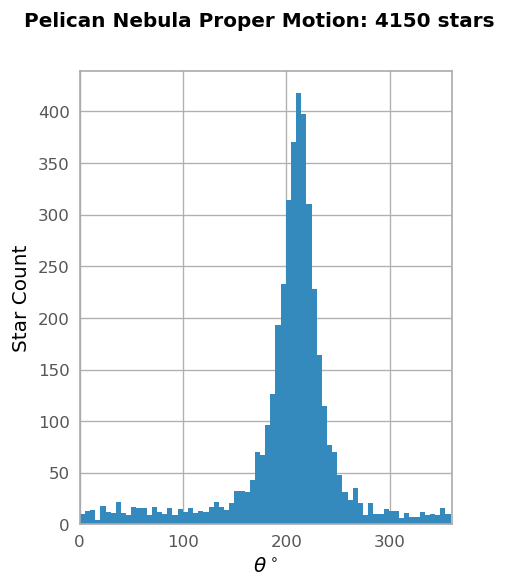

In [5]:
#
# Create a histogram plot of the stars, showing the distribution of the 
# PM angle (arctan(pmdec/pmdra))
#
n_bins =72
fig3, ax3 = plt.subplots(figsize=(4,5),dpi=120)
fig3.suptitle('Pelican Nebula Proper Motion: '+ str(len(stars_pm))+ ' stars', 
              fontsize=12, fontweight='bold')

ax3.set_xlabel(r"$\theta^\circ$")
ax3.set_xlim(0,360)
ax3.set_ylabel('Star Count')
x = []

x = compute_pm_angles(stars_pm)
ax3.hist(x, bins=n_bins)

plt.show()



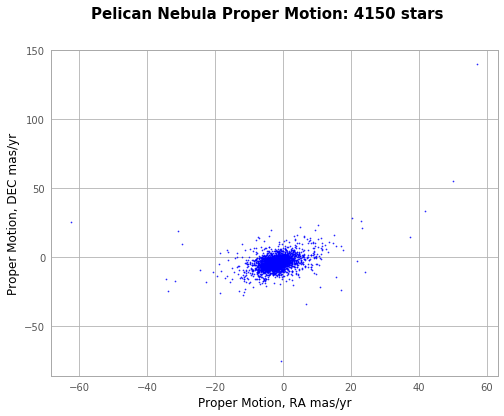

In [6]:
# Parallax plots

fig, ax = plt.subplots(figsize=(8,6))
#fig.subplots_adjust(top=.85)
fig.suptitle('Pelican Nebula Proper Motion: '+ str(_star_count) + ' stars',
             fontsize=15, fontweight='bold')

# ax.set_title(title)
ax.set_xlabel('Proper Motion, RA mas/yr')
ax.set_ylabel('Proper Motion, DEC mas/yr')

X = stars_pm['pmra']
Y = stars_pm['pmdec']
Z = stars_pm['parallax']

ax.scatter(X,Y, color='b', alpha=0.8, s=.5)

plt.show()

# percentage to shrink the min/max - the plot fails unless we do this
sh = .1

xmin,xmax,ymin,ymax,zmin,zmax = myshrink(X,Y,Z,sh)

ipv.clear()

ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Parallax')
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(zmin,zmax)

ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Parallax')

ipv.scatter(X, Y, Z, size=2, marker="sphere",
            xlabel='RA',ylabel='Dec',zlabel='Parallax')
ipv.show()
plt.close()

In [23]:
#ipywidgets-display::
# do a 3d plot of pmra pmdec cross-corrletation
import ipyvolume as ipv
import numpy as np
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

X = stars_pm['ra']
Y = stars_pm['dec']
U = stars_pm['pmra'] * 36000
V = stars_pm['pmdec'] * 36000
Z = stars_pm['pmra_pmdec_corr']

shrink = .1 # percentage to shrink the min/max - the plot fails unless we do this
xmin,xmax,ymin,ymax,zmin,zmax = myshrink(X,Y,Z,shrink)

ipv.clear()
ipv.figure(width=_figwidth,height=_figheight)
ipv.style.use("dark") # looks better
ipv.xyzlabel('RA','Dec', 'PMRA_PMDec Corr')
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(zmin,zmax)

quiver = ipv.quiver(X,Y,Z,U,V,Z,size=2,size_selected=6,alpha=.8)

selected = []
sz = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
col = ColorPicker()
color_selected = ColorPicker()

jslink((quiver, 'size'), (sz, 'value'))
jslink((quiver, 'color'), (col, 'value'))
VBox([ipv.gcc(), sz, col])
ipv.show()

In [20]:
#
# Function to plot a 3D scatterplot given an array of x,y,z,colors
# and title, xlabel, ylabel, zlabel and SuperTitle
# 2/2019 -egs-

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

def scatter3d(x, y, z, cs, colorsMap='jet',
              title=None,xlabel='X', ylabel='Y',zlabel='Z',
              xsize=6, ysize=4, suptitle=None, markersize=None):
    
    cm = plt.get_cmap(colorsMap)
    cNorm = colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    scalarMap.set_array(cs)

    fig = plt.figure(figsize=(xsize,ysize))
    if (suptitle):
        fig.suptitle(suptitle,fontweight='bold',fontsize=16)

    ax = Axes3D(fig)
    
    if (title):
        ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 10
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(45)
    fig.subplots_adjust(bottom=.3)
    fig.colorbar(scalarMap)
    
    if markersize is None:
        ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))      
    else:
        ax.scatter(x, y, z, c=scalarMap.to_rgba(cs),s=markersize)
    ax.view_init(20, 35)  
plt.show()
####

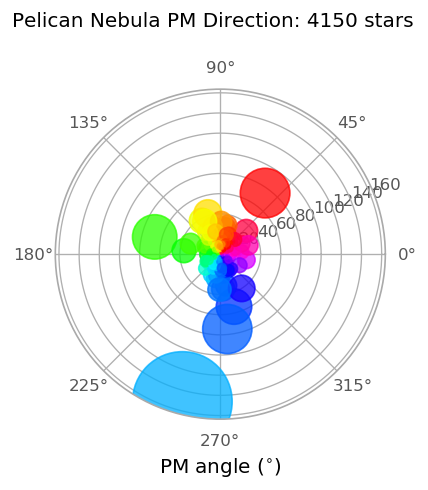

In [22]:
#
# Polar plot of PMRA and PMDec
# the PMRA and PMDEC to polar coordinates and then query against a specific angle

# convert cartesian coords to polar
r = []
theta = [] # list containing the polar coordinate angles
area = []

from egs import normalized

def compute_pm(stars):
    def cart2ang(x, y):
        rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(x,y)
        phi+=180.0
        return(rho,phi)

    tot = len(stars)
    ang = [0.0] * tot
    rho = [0.0] * tot
    
    for i in range(tot):
        rho[i], ang[i] = cart2ang(stars[i]['pmra'],stars[i]['pmdec'])
    return(rho, ang)
#
r, theta = compute_pm(stars_pm)
rmax = np.max(r)
rmin = np.min(r)

cols = theta

colorsMap='jet'
cm = plt.get_cmap(colorsMap)
cNorm = normalized(r)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
scalarMap.set_array(r)

# scale the circles proportional to their size

i = 0
tot = len(r)
for i in range(tot):
    area.append(r[i]*r[i]*np.pi/20)

fig = plt.figure(figsize=(5,5),dpi=120)
ax = fig.add_subplot(111, projection='polar')

fig.suptitle('Pelican Nebula PM Direction: '+ str(_star_count)+ ' stars', fontsize=12)
fig.subplots_adjust(top=.85)

ax.set_xlabel('PM angle ($^{\circ}$)')

#ax.scatter(theta, r, c=cols, s=area, cmap='hsv', alpha=0.75)
ax.scatter(theta, r, c=cols,s=area, cmap='hsv', alpha=0.75)

fig.subplots_adjust(bottom=.3)
plt.show()


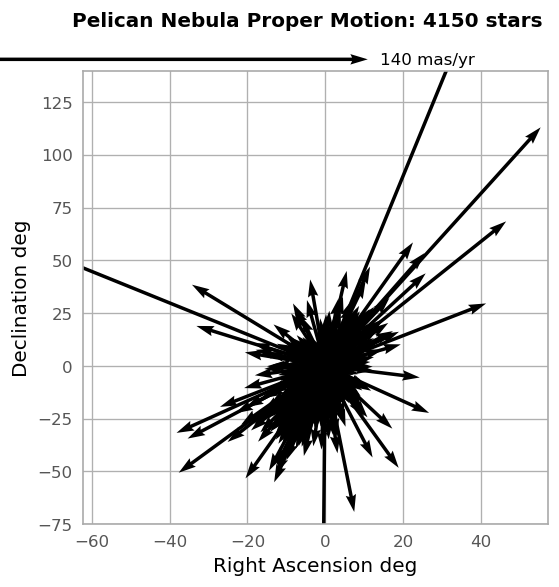

In [10]:
#
# Create a quiver plot of the stars, where the pmra and pmdec determine the 
# orientation of the arrows
#

def determine_qkey_len2(stars,field1,field2):
    pmra_min = abs(np.min(stars[field1]))
    pmra_max = abs(np.max(stars[field1]))
    pmdec_min = abs(np.min(stars[field2]))
    pmdec_max = abs(np.max(stars[field2]))
    pm = [pmra_min, pmra_max, pmdec_min, pmdec_max]
    return(int(max(pm)+.5))

fig, ax = plt.subplots(figsize=(5,5),dpi=120)
fig.suptitle('Pelican Nebula Proper Motion: '+ str(_star_count)+ ' stars', 
              fontsize=12, fontweight='bold')

ax.set_xlabel('Right Ascension deg')
ax.set_ylabel('Declination deg')

# determine the length of the quiverkey and make the string label
qk_len = determine_qkey_len2(stars_pm,'pmra','pmdec')
qk_str = str(qk_len) + ' mas/yr'

# This quiver plot requires 4 inputs: the X positions and Y positions for each 
# point and their U and V directions, (their proper motions in this case, 
# oriented relative to the RA and DEC axes) to get these, simply slice 
# the stars table along the proper columns to create the relevant array

# this needs to be converted to cartesian! 
X = stars_pm['ra']
Y = stars_pm['dec']
U = stars_pm['pmra']
V = stars_pm['pmdec']
Z = stars_pm['parallax']

xmin = U.min()
xmax = U.max()
ymin = V.min()
ymax = V.max()
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)


quiver_plot = ax.quiver(0,0, U, V, angles='uv', units='dots')
#quiver_plot_fast = ax2c.quiver(Xf, Yf, Uf, Vf, angles='xy', units='xy', color='r')
ax.quiverkey(quiver_plot, X=0.6, Y=0.9, U=qk_len,
             label=qk_str, labelpos='E', coordinates='figure')

plt.show()

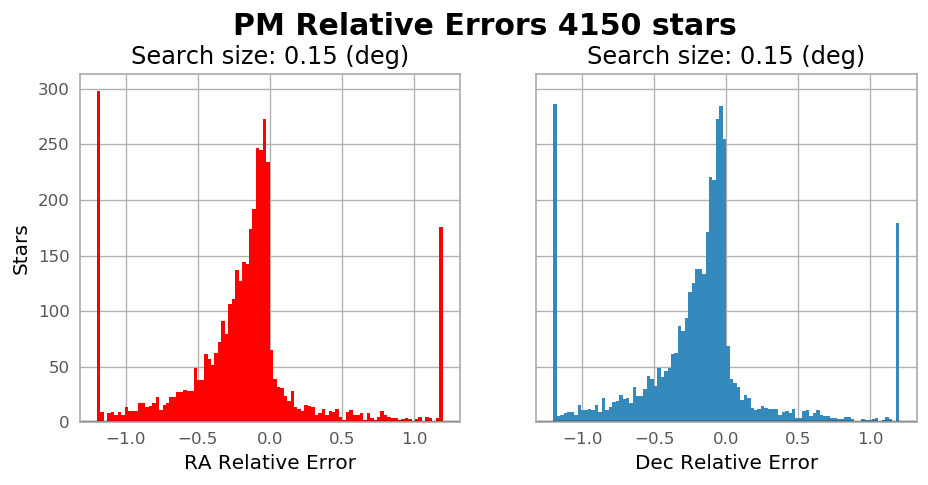

In [11]:
#
# Compute the PM relative errors and graph them
#
plt_title = "Pelican PM Analysis: " + str(_star_count) + " stars (" + str(_size) + "$^{\circ}$)"
ra_error = stars_pm['pmra_error']/stars_pm['pmra']
dec_error = stars_pm['pmdec_error']/stars_pm['pmra']

# Statistics:
# Printing these can take time with long lists

#
#print("RA errors min, max:", ra_error.min(), " ", ra_error.max())
#print("Dec errors min, max:", dec_error.min(), " ", ra_error.max())

# print('Statistics prior to clipping: \n')
# print('Statistics for RA:',stats.describe(ra_error),'\n')
# print('Statistics for dec:',stats.describe(dec_error),'\n')

# now clamp the relative ra and dec errors into -1.2 => 1.2
# anthing < -1 or > 1 is bad

clean_ra = []
clean_dec = []

errorx = 0.0
errory = 0.0

for x,y in zip(dec_error,ra_error):
    errorx = np.clip(x,-1.2,1.2)
    clean_dec.append(errorx)
    errory = np.clip(y,-1.2,1.2)
    clean_ra.append(errory)

# print('Statistics after clipping: \n')
# print('Statistics for RA:',stats.describe(clean_ra))
# print('Statistics for RA:',stats.describe(clean_dec))

# Plot histograms for the PM Errors
n_bins = 100
plt_title = "PM Relative Errors "

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True,figsize=(9,4), dpi=120)

fig.suptitle(plt_title + str(_star_count)+ ' stars',
             fontsize=18, fontweight='bold')
fig.subplots_adjust(top=.85)
title = "Search size: " + str(_size) + " (deg)"

ax1.grid(True)
ax1.axhline(0, color='black', lw=2)
ax1.set_xlabel('RA Relative Error')
ax1.set_ylabel('Stars')
ax2.set_xlabel('Dec Relative Error')
ax1.set_title(title)
ax2.set_title(title)

ax2.grid(True)
ax2.axhline(0, color='black', lw=2)

ax1.hist(clean_ra, bins=100,color='red')
ax2.hist(clean_dec, bins=100)

plt.show()



In [12]:
#ipywidgets-display::
# Plot the pmra and pmdec as a quiver plot against parallax and position
import ipyvolume as ipv
import numpy as np
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

X = (stars_pm['ra'])
Y = (stars_pm['dec'])
U = (stars_pm['pmra'])
V = (stars_pm['pmdec'])
Z = (stars_pm['parallax'])

#Z = (to_deg * np.arctan(stars_pm['pmdec'],stars_pm['pmra']) + 360) % 360 # convert the angle into 0-360 deg
shrink = .05 # percentage to shrink the min/max - the plot fails unless we do this

sh = .1 # percentage to shrink the min/max - the plot fails unless we do this
xmin,xmax,ymin,ymax,zmin,zmax = myshrink(stars_pm['ra'],
                                         stars_pm['dec'],
                                         stars_pm['parallax'],sh)
#print(xmin,xmax,ymin,ymax,zmin,zmax)
#ipv.clear()

_figwidth=800
_figheight=800

ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Parallax')
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.style.use("dark")
plt_title = "PM Relative Errors "
quiver = ipv.quiver(X,Y,Z,U,V,Z,size=3,size_selected=8)

selected = []
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()

jslink((quiver, 'size'), (size, 'value'))
jslink((quiver, 'color'), (color, 'value'))
VBox([ipv.gcc(), size, color])


In [13]:
#ipywidgets-display::
# PMDEC/PMRA angle quiver plot

import ipyvolume as ipv
import numpy as np
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

# compute proper motion angle, return in degrees 0-360

X = stars_pm['ra']
Y = stars_pm['dec']
U = stars_pm['pmra']
V = stars_pm['pmdec']

angles = compute_pm_angles(stars_pm) # convert the angle into 0-360 deg

Z = np.asarray(angles)

sh = .05 # percentage to shrink the min/max - the plot fails unless we do this
xmin,xmax,ymin,ymax,zmin,zmax = myshrink(stars_pm['ra'],
                                         stars_pm['dec'],
                                         angles,sh)
ipv.clear()
ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Angle')
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(zmin,zmax)
ipv.style.use("dark")

quiv = ipv.quiver(X,Y,Z,U,V,Z,size=2,size_selected=8)

selected = []
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()

jslink((quiv, 'size'), (size, 'value'))
jslink((quiv, 'color'), (color, 'value'))
VBox([ipv.gcc(), size, color])



In [14]:
#ipywidgets-display::
# Parallax 3D Quiver
import ipyvolume as ipv
import numpy as np
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

X = stars_pm['ra']
Y = stars_pm['dec']
U = stars_pm['pmra'] * 1000000
V = stars_pm['pmdec'] * 1000000
Z = stars_pm['parallax']

sh = .05 # percentage to shrink the min/max - the plot fails unless we do this
xmin,xmax,ymin,ymax,zmin,zmax = myshrink(stars_pm['ra'],
                                         stars_pm['dec'],
                                         stars_pm['parallax'],sh)

ipv.clear()
ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Parallax')
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.style.use("dark")

quiv3 = ipv.quiver(X,Y,Z,U,V,Z,size=2,size_selected=8)

selected = []
size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()

jslink((quiv3, 'size'), (size, 'value'))
jslink((quiv3, 'color'), (color, 'value'))
VBox([ipv.gcc(), size, color])

In [15]:
#ipywidgets-display::
# pmra pmdec corrleation 3d scatter

import ipyvolume as ipv
import numpy as np
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

X = stars_pm['ra']
Y = stars_pm['dec']
Z = stars_pm['pmra_pmdec_corr']

sh = .05 # percentage to shrink the min/max - the plot fails unless we do this
xmin,xmax,ymin,ymax,zmin,zmax = myshrink(X,Y,Z,sh)

ipv.clear()
ipv.figure(width=_figwidth,height=_figheight)
ipv.xyzlabel('RA','Dec', 'Corr')
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(zmin,zmax)
ipv.style.use("dark")

scatt = ipv.scatter(X,Y,Z,size=2,size_selected=8,marker='box')

size = FloatSlider(min=0, max=30, step=0.1)

cp = ColorPicker()

jslink((scatt, 'size'), (size, 'value'))
jslink((scatt, 'color'), (cp, 'value'))
VBox([ipv.gcc(), size, color])

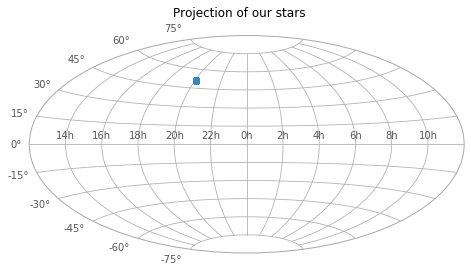

In [16]:
#
# Plot the position of our stars on a projection of the Sky. Extracts the angular
# coordinates from a normal Gaia query and plots them using an Aitoff projection
# useful example of how to get coordinates out and manipulate them
# 3/3/19 -egs-
#
import astropy.coordinates as coord
import math

"""
# the following shows how to pull the coordinates out as raw numbers into a list
p = {}
pos = []

for star in stars_pm:
    id = star['source_id']
    p = (star['ra'],star['dec'])
    pos.append(p)

# the following converts into arrays

ra_list = np.array(stars_pm['ra'])
dec_list = np.array(stars_pm['dec'])

"""

ra = coord.Angle(stars_pm['ra'].filled(np.nan)*u.degree)
ra = ra.wrap_at(180*u.degree)

dec = coord.Angle(stars_pm['dec'].filled(np.nan)*u.degree)

fig = plt.figure(figsize=(8,4))
fig.suptitle("Projection of our stars")
#fig.subplots_adjust(top=.8)
#plt.grid(True)

ax = plt.subplot(111, projection="aitoff")

ax.scatter(ra.radian, dec.radian)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

plt.show()

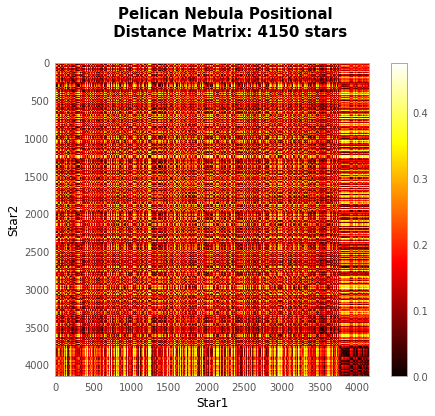

In [17]:
# calculating the distance matrix over the stars positions
from scipy.spatial import distance_matrix
import numpy as np; np.random.seed(0)

fig, ax = plt.subplots(figsize=(8,6))
fig.subplots_adjust(top=.85)
fig.suptitle('Pelican Nebula Positional \n Distance Matrix: '+ str(_star_count) + ' stars',
             fontsize=15, fontweight='bold')

ax.set_xlabel('Star1')
ax.set_ylabel('Star2')

p = {}
pos = []

for star in stars_pm:
    p = (star['ra'],star['dec'])
    pos.append(p)

dm = distance_matrix(pos,pos)

im = ax.imshow(dm,cmap='hot', interpolation='nearest')
plt.colorbar(im);

ax.grid(False)

plt.show()

i = 0
z = [0.0]*_star_count

# plot it as a meshgrid, z as altitude, _star_count*_star_count size
#for x in range(_star_count):
#    for y in range(_star_count):
#        z[i] = dm[x][y]

#

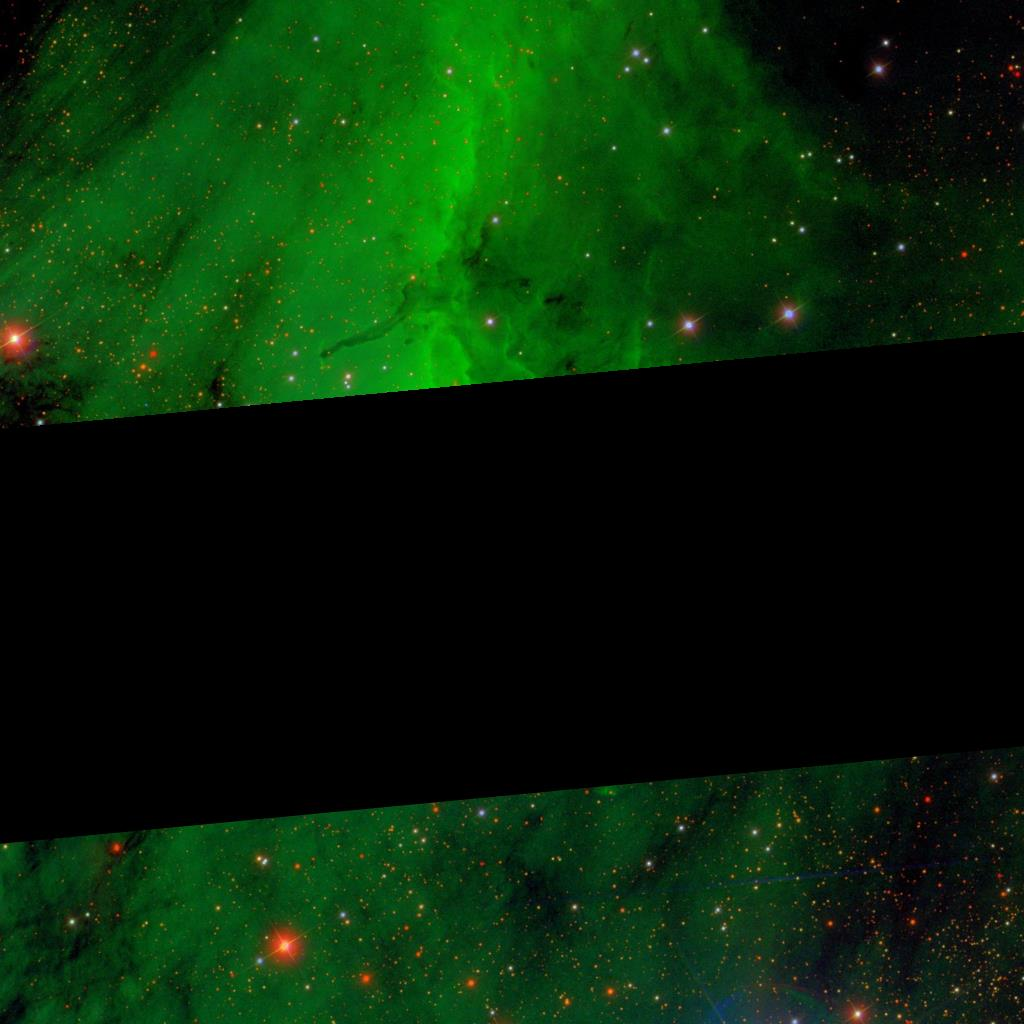

In [18]:

# this cell imports functions from the python standard library in a way that works with both python 2 and 3

try:
    # Python 3.x
    from urllib.parse import urlencode
    from urllib.request import urlretrieve
except ImportError:
    # Python 2.x
    from urllib import urlencode
    from urllib import urlretrieve
import IPython.display

# default search location
pel_ra = 20.8467 * 15 # convert to degrees!
pel_dec = 44.35

# grab a picture from SDSS
#

def get_sdss_image(ra,dec,ang_size,filename):
    """Retreives an centered on the input coordinates of angular size ang_size (min)
    and filename filename.

    Parameters
    ----------
    ra,dec : Right Ascension and Declination 
    ang_size : angular size for the image, minutes
    filename: file name for the image

    Returns
    -------
    The file is retrieved and saved. Use Ipython.display.Image(filename) to view
    """
    
    centerpoint = SkyCoord(ra*u.deg,dec*u.deg, frame='icrs')
    impix = 1024
    imsize = ang_size*u.arcmin
    cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
    query_string = urlencode(dict(ra=centerpoint.ra.deg, 
                                     dec=centerpoint.dec.deg, 
                                     width=impix, height=impix, 
                                     scale=imsize.to(u.arcsec).value/impix))
    url = cutoutbaseurl + '?' + query_string
    # this downloads the image to your disk
    urlretrieve(url, filename)
    return()

get_sdss_image(pel_ra,pel_dec,30.0,"pelican.jpg")
IPython.display.Image("pelican.jpg")

### End of Notebook